In [ ]:
##Training

In [1]:
import tensorflow as tf
print(tf.__version__)

1.12.0


In [2]:
import keras
print(keras.__version__)

2.2.2


Using TensorFlow backend.


In [3]:
import sys

In [4]:
#from __future__ import print_function #may need this, just took it out because running the .py from anaconda prompt complained

import cv2   #CMT something to do with computer vision and hardware acceleration. Perhaps linked to GPU?
from keras.models import Model
from keras.layers import Input, Dropout, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

K.set_image_dim_ordering('th')  # Theano dimension ordering in this code


In [5]:
sys.executable

'C:\\Users\\cht17\\AppData\\Local\\Continuum\\anaconda3\\envs\\tensorflowChris\\python.exe'

In [6]:
#THEANO_FLAGS=device=gpu,floatX=float32 #python #my_keras_script.py

In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17169439315502754155
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11130201703
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3060205075192537762
physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:17:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 4053676852
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10135045815871323016
physical_device_desc: "device: 1, name: Quadro P2000, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


In [8]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True)) #what does this do?!?!?!

In [9]:
import niftynet

INFO:tensorflow:TensorFlow version 1.12.0


C:\Users\cht17\AppData\Local\Continuum\anaconda3\envs\tensorflowChris\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


INFO:tensorflow:Available Image Loaders:
['nibabel', 'opencv', 'skimage', 'pillow', 'simpleitk', 'dummy'].


In [10]:
import numpy as np
import nibabel as nib
import json

In [11]:
import matplotlib.pyplot as plt

In [12]:
import os
import pylab
from PIL import Image

In [13]:
ArrayCT = np.load("D:/CNNdata/SynCT_LargerCohort_v3/CT24ptsTrainNorm/CT24ptsTrainNorm.npy")

In [14]:
ArrayMR = np.load("D:/CNNdata/SynCT_LargerCohort_v3/MR24ptsTrainNorm/MR24ptsTrainNorm.npy")

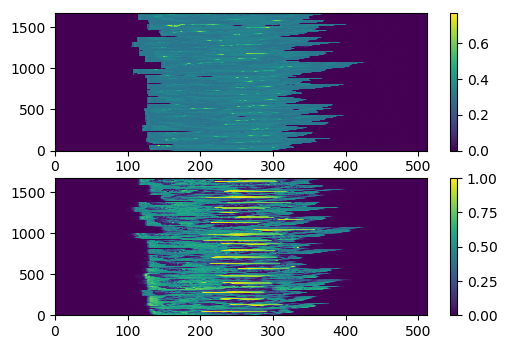

In [15]:

plt.figure(dpi=100)
plt.axes().set_aspect('equal', 'datalim')
n=230
m=n+121
plt.subplot(2,1,1)
plt.pcolormesh(ArrayCT[:,0,:,n])
plt.colorbar()
plt.subplot(2,1,2)
plt.pcolormesh(ArrayMR[:,0,:,n])
plt.colorbar()


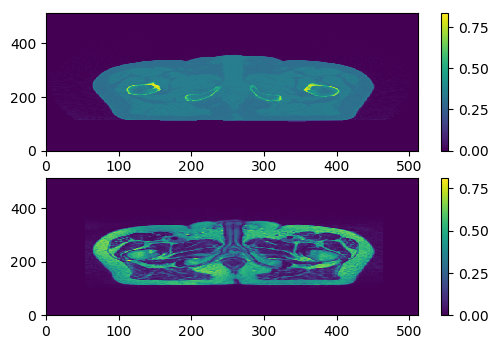

In [16]:
plt.figure(dpi=100)
plt.axes().set_aspect('equal', 'datalim')
plt.subplot(2,1,1)
sample = 1345
plt.pcolormesh(ArrayCT[sample,0,:,:])
plt.colorbar()
plt.subplot(2,1,2)
plt.pcolormesh(ArrayMR[sample,0,:,:])
plt.colorbar()

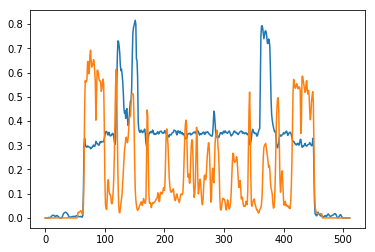

In [17]:
plt.plot(ArrayCT[sample,0,245,:])
plt.plot(ArrayMR[sample,0,245,:])
#through femoral heads

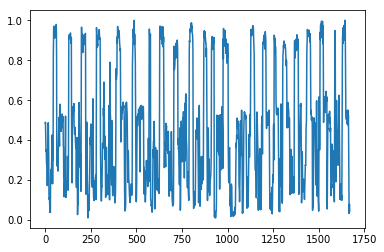

In [18]:
plt.plot(ArrayMR[:,0,250,250])

In [19]:
np.min(ArrayMR)

0.0

In [20]:
np.max(ArrayMR)

1.0

In [21]:
run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

In [22]:
def get_unet():  
    
    inputs = Input((1, image_rows, image_cols)) 
    
    conv1 = Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
    
    D1=Dropout(0.2)(conv1) #need this?
    
    conv1 = Conv2D(32, (5, 5), activation='relu', padding='same')(D1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    #now at 256x256
    
    conv2 = Conv2D(64, (5, 5), activation='relu', padding='same')(pool1)
    D2=Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (5, 5), activation='relu', padding='same')(D2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    #now at 128x128

    conv3 = Conv2D(128, (5, 5), activation='relu', padding='same')(pool2)
    D3=Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (5, 5), activation='relu', padding='same')(D3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    #now should be at 64x64
    
    conv4 = Conv2D(256, (5, 5), activation='relu', padding='same')(pool3)
    D4=Dropout(0.2)(conv4)
    conv4 = Conv2D(256, (5, 5), activation='relu', padding='same')(D4)
    
    
    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=2, padding='valid')(conv4), conv3], axis=1)
    conv8 = Conv2D(128, (5, 5), activation='relu', padding='same')(up8)
    D8=Dropout(0.2)(conv8)
    conv8 = Conv2D(128, (5, 5), activation='relu', padding='same')(D8)
    
    
    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=2, padding='valid')(conv8), conv2], axis=1)
    conv9 = Conv2D(64, (5, 5), activation='relu', padding='same')(up9)
    D9=Dropout(0.2)(conv9)
    conv9 = Conv2D(64, (5, 5), activation='relu', padding='same')(D9)

    up10 = concatenate([Conv2DTranspose(32, (2, 2), strides=2, padding='valid')(conv9), conv1], axis=1)
    conv10 = Conv2D(32, (5, 5), activation='relu', padding='same')(up10)
    D10=Dropout(0.2)(conv10)
    conv10 = Conv2D(32, (5, 5), activation='relu', padding='same')(D10)

    conv11 = Conv2D(1, (1, 1), activation='linear')(conv10)
    
    model = Model(input=inputs, output=conv11)
    
    return model

In [23]:
image_rows = 512
image_cols = 512

In [24]:
model = get_unet()

In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 512, 512)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 512, 512) 832         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 512, 512) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 512, 512) 25632       dropout_1[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [26]:
# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [27]:
#model.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error', metrics=['mae'], options = run_opts)
model.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error', metrics=['mae'])

In [28]:
print('-'*30)
print('Fitting model...')
print('-'*30)
## the input data (MR) and then the mask (CT)
history = model.fit(ArrayMR, ArrayCT, batch_size=1, epochs=100, verbose=1, shuffle=True)
        #  callbacks=[model_checkpoint])

# #     with open('/trainHistoryDict' + str(i), 'wb') as file_pi:
# #         pickle.dump(history.history, file_pi)
# with open('file' +str(i) +'.json', 'w') as f:
#     json.dump(history.history, f)

------------------------------
Fitting model...
------------------------------
Epoch 1/100
1671/1671 [==============================] - 186s 111ms/step - loss: 0.0015 - mean_absolute_error: 0.0146
Epoch 2/100
1671/1671 [==============================] - 188s 113ms/step - loss: 5.3864e-04 - mean_absolute_error: 0.0083
Epoch 3/100
1671/1671 [==============================] - 189s 113ms/step - loss: 4.2420e-04 - mean_absolute_error: 0.0072
Epoch 4/100
1671/1671 [==============================] - 187s 112ms/step - loss: 3.6386e-04 - mean_absolute_error: 0.0066
Epoch 5/100
1671/1671 [==============================] - 185s 111ms/step - loss: 3.1309e-04 - mean_absolute_error: 0.0062
Epoch 6/100
1671/1671 [==============================] - 185s 111ms/step - loss: 3.0762e-04 - mean_absolute_error: 0.0061
Epoch 7/100
1671/1671 [==============================] - 184s 110ms/step - loss: 2.6412e-04 - mean_absolute_error: 0.0057
Epoch 8/100
1671/1671 [==============================] - 184s 110ms/ste

1671/1671 [==============================] - 183s 110ms/step - loss: 6.5515e-05 - mean_absolute_error: 0.0034
Epoch 68/100
1671/1671 [==============================] - 183s 109ms/step - loss: 6.5221e-05 - mean_absolute_error: 0.0034
Epoch 69/100
1671/1671 [==============================] - 184s 110ms/step - loss: 6.4781e-05 - mean_absolute_error: 0.0034
Epoch 70/100
1671/1671 [==============================] - 184s 110ms/step - loss: 6.4675e-05 - mean_absolute_error: 0.0034
Epoch 71/100
1671/1671 [==============================] - 184s 110ms/step - loss: 6.3900e-05 - mean_absolute_error: 0.0034
Epoch 72/100
1671/1671 [==============================] - 185s 111ms/step - loss: 6.3918e-05 - mean_absolute_error: 0.0034
Epoch 73/100
1671/1671 [==============================] - 185s 111ms/step - loss: 6.3390e-05 - mean_absolute_error: 0.0034
Epoch 74/100
1671/1671 [==============================] - 183s 110ms/step - loss: 6.3205e-05 - mean_absolute_error: 0.0034
Epoch 75/100
1671/1671 [=====

In [29]:
# https://machinelearningmastery.com/save-load-keras-deep-learning-models/
# trying to save the model so that it can be loaded in another script and tested on other data

# serialize model to JSON
model_json = model.to_json()
with open("D:/CNNdata/SynCT_LargerCohort_v3/TrainedModel/24ptModelv3.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("D:/CNNdata/SynCT_LargerCohort_v3/TrainedModel/24ptModelv3.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")